### Time Series Data – Stock Price Prediction

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
%matplotlib inline

Next, we'll load the .csv file, using the read_csv() method from Pandas, into a DataFrame (inp0) and have a look at a few records using the head method of the pandas DataFrame

In [2]:
inp0 = pd.read_csv('AAPL.csv')
inp0.head()

,Date,Close,Open,High,Low,Volume
0,1/17/2020,138.31,136.54,138.330,136.16,5623336
1,1/16/2020,137.98,137.32,138.190,137.01,4320911
2,1/15/2020,136.62,136.00,138.055,135.71,4045952
3,1/14/2020,135.82,136.28,137.139,135.55,3683458
4,1/13/2020,136.60,135.48,136.640,135.07,3531572


#### Exercise 5.01: Visualizing Our Time-Series Data
In this exercise, we will extract the closing price from the data, perform the necessary formatting, and plot the time series to gain a better understanding of the data. Make sure that you have read through the preceding section and loaded the data, as well as imported the relevant libraries. Perform the following steps to complete this exercise:

Plot the Close column as a line plot to see the pattern using the plot method of the DataFrame, specifying the Date column as the X-axis

<AxesSubplot:xlabel='Date'>

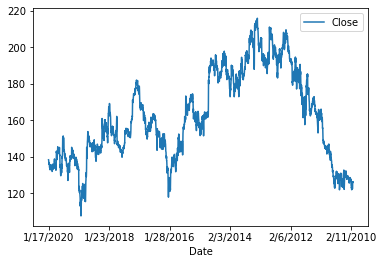

In [3]:
inp0.plot('Date', 'Close')
#plt.show()

From the plot, we can see that the latest values are getting plotted first (on the left). We'll reverse the data for convenience of plotting and handling. We'll achieve this by sorting the DataFrame by the index (remember that the index was 0 for the latest record) in descending order.

Reverse the data by sorting the DataFrame on the index. Plot the closing price again and supply Date as the X-axis

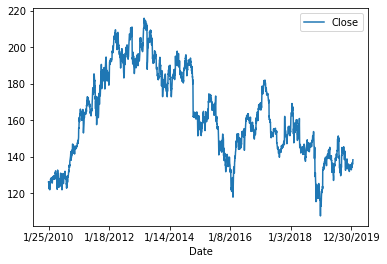

In [4]:
inp0 = inp0.sort_index(ascending=False)
inp0.plot('Date', 'Close')
plt.show()

Extract the values for Close from the DataFrame as a numpy array, reshaped to specify one column using array.reshape(-1,1)

In [5]:
ts_data = inp0.Close.values.reshape(-1,1)

Plot the values as a line plot using matplotlib. Don't worry about marking the dates; the order of the data is clear (matplotlib will use an index instead, beginning with 0 for the first point)

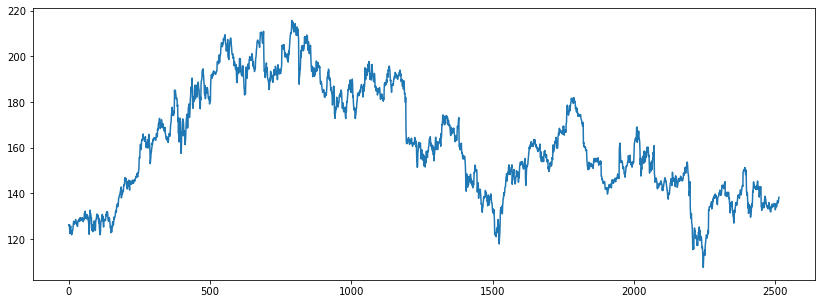

In [6]:
plt.figure(figsize=[14, 5])
plt.plot(ts_data)
plt.show()

That's what our sequence data looks like. There is no continuous clear trend; the prices rose for a period, after which the stock waxed and waned. The pattern isn't straightforward. We can see that there is some seasonality at a small duration (maybe monthly). Overall, the pattern is rather complex and there are no obvious and easy-to-identify cyclicities in the data that we can exploit. This complex sequence is what we will work with – predicting the stock price for a day using historical values.

In [7]:
# create train-test split of data allocating first 75% and last 25% to train, test respectively
train_recs = int(len(ts_data) * 0.75)

This is the number of records we'll have in the train set. We can separate the sets as follows:

In [8]:
train_data = ts_data[:train_recs] # all the records from the first 75% of data (index 0-1884)
test_data = ts_data[train_recs:] # index 1885-2513
len(train_data), len(test_data)

(1885, 629)

Next, we need to scale the stock data. For that, we can employ the min-max scaler from sklearn. The MinMaxScaler scales the data so that it's in a range between 0 and 1 (inclusive) – the highest value in the data being mapped to 1. We'll fit and transform the scaler on the train data and only transform the test data:

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

The next important step is to format the data to get the "features" for each instance. We need to define a "lookback period" – the number of days from the history that we want to use to predict the next value. The following code will help us define a function that returns the target value of y (stock price for a day) and X (values for each day in the lookback period):

In [10]:
def get_lookback(inp, look_back):
    y = pd.DataFrame(inp)
    dataX = [y.shift(i) for i in range(1, look_back+1)] # Shift index by desired number of periods
    dataX = pd.concat(dataX, axis=1)
    dataX.fillna(0, inplace=True)
    return dataX.values, y.values

The function takes in a dataset (a series of numbers, rather) and, for the provided lookback, adds as many values from the history. It does so by shifting the series, each time concatenating it to the result. The function returns the stock price for the day as y and the values in lookback period (shifted values) as our features. Now, we can define a lookback period and see the result of applying the function to our data:

In [11]:
look_back = 10

In [12]:
trainX, trainY = get_lookback(train_scaled, look_back=look_back)
testX, testY = get_lookback(test_scaled, look_back=look_back)

In [13]:
trainX.shape, testX.shape

((1885, 10), (629, 10))

As expected, there are 10 features for each example, corresponding to the past 10 days. We have this history for the train data as well as the test data. With that, data preparation is complete. Before we move on to building our first RNN on this data, let's understand RNNs a little more.

#### Training RNNs

Building first RNN model using Keras.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Activation, Dropout, Dense, Reshape

#### Exercise 5.03: Building Our First Plain RNN Model
In this exercise, we will build our first plain RNN model. We will have a reshape layer, followed by a SimpleRNN layer, followed by a dense layer for the prediction. We will use the formatted data for trainX and trainY that we created earlier, along with the initialized layers from Keras.

In [15]:
# Instantiate the Sequential model
model = Sequential()

2022-06-28 06:09:52.708570: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# Add a Reshape layer to get the data in the format (look_back, 1)
model.add(Reshape((look_back, 1),input_shape = (look_back,)))

Add a SimpleRNN layer with 32 neurons and specify the input shape. Note that we took an arbitrary number of neurons, so you're welcome to experiment with this number

In [17]:
model.add(SimpleRNN(32, input_shape=(look_back, 1)))

In [18]:
# Add a Dense layer of size 1
model.add(Dense(1))

In [19]:
# Add an Activation layer with a linear activation
model.add(Activation('linear'))

In [20]:
# Compile the model with the adam optimizer and mean_squared_error (since we're predicting a real-values quantity)
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

In [21]:
# print summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 10, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


#### Model Training and Performance Evaluation
We can do this by using a batch size of 1 and a validation split of 10%, and by training for only three epochs.

In [22]:
model.fit(trainX, trainY, epochs=3, batch_size=1, verbose=2, validation_split=0.1)

Epoch 1/3
1696/1696 - 3s - loss: 0.0026 - val_loss: 8.8805e-04 - 3s/epoch - 2ms/step
Epoch 2/3
1696/1696 - 2s - loss: 0.0010 - val_loss: 0.0011 - 2s/epoch - 1ms/step
Epoch 3/3
1696/1696 - 2s - loss: 9.3357e-04 - val_loss: 3.5552e-04 - 2s/epoch - 1ms/step


Let's begin by defining our first function, using the sqrt function from math to get the root of the mean_squared_error provided to us by the model's evaluate method.

In [23]:
import math
def get_model_perf(model_obj):
    score_train = model_obj.evaluate(trainX, trainY, verbose=0)
    print('Train RMSE: %.2f RMSE' %(math.sqrt(score_train)))
    score_test = model_obj.evaluate(testX, testY, verbose=0)
    print('Test RMSE: %.2f RMSE' %(math.sqrt(score_test)))

In [24]:
get_model_perf(model)

Train RMSE: 0.02 RMSE
Test RMSE: 0.03 RMSE


The following code will help us define a function that plots the predictions for a given model object

In [25]:
def plot_pred(model_obj):
    testPredict = scaler.inverse_transform(model_obj.predict(testX))
    pred_test_plot = ts_data.copy()
    pred_test_plot[:train_recs+look_back,:] = np.nan
    pred_test_plot[train_recs+look_back:,:] = testPredict[look_back:]
    plt.plot(ts_data)
    plt.plot(pred_test_plot, '--')

In [26]:
type(ts_data)

numpy.ndarray

First, the function makes predictions on the test data. Since this data is scaled, we apply the inverse transform to get the data back to its original scale before plotting it. The function plots the actual values as a solid line and the predicted values as dotted lines. 

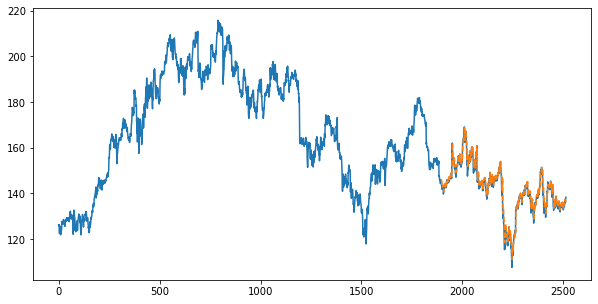

In [27]:
%matplotlib inline
plt.figure(figsize=[10,5])
plot_pred(model)

In [28]:
%matplotlib notebook
plot_pred(model)

<IPython.core.display.Javascript object>

#### Exercise 5.04: Building a 1D Convolution-Based Model
In this exercise, we will build our first model using 1D convnets and evaluate its performance. We'll employ a single Conv1D layer, followed by MaxPooling1D

In [29]:
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten

In [30]:
# Initialize a Sequential model and add a Reshape layer to reshape each instance as a vector (look_back, 1)
model_conv = Sequential( )
model_conv.add(Reshape((look_back, 1), input_shape=(look_back,)))

In [31]:
# Add a Conv1D layer with five filters of size 5 and relu as the activation function
model_conv.add(Conv1D(5, 5, activation='relu'))

In [32]:
# Add a Maxpooling1D layer with a pool size of 5:
model_conv.add(MaxPool1D(5))

In [33]:
# Flatten the output with a Flatten layer:
model_conv.add(Flatten())

In [34]:
# Add a Dense layer with a single neuron and add a linear activation layer:
model_conv.add(Dense(1))
model_conv.add(Activation('linear'))

In [35]:
# Print out the summary of the model:
model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 10, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 6, 5)              30        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 5)             0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                      

Notice the dimensions of the output from the Conv1D layer – 6 x 5. This is expected – for a filter size of 5, we get 6 features. Also, take a look at the overall number of parameters. It's just 36, which is indeed a very small number.

In [36]:
# Compile the model with the loss as mean_squared_error and adam as the optimizer, and then fit it on the train data for 5 epochs
model_conv.compile(
    loss='mean_squared_error',
    optimizer='adam'
)
model_conv.fit(
    trainX, 
    trainY, 
    epochs=5,
    batch_size=1,
    verbose=2,
    validation_split=0.1
)

Epoch 1/5
1696/1696 - 1s - loss: 0.0913 - val_loss: 0.0014 - 1s/epoch - 694us/step
Epoch 2/5
1696/1696 - 1s - loss: 0.0040 - val_loss: 8.3635e-04 - 886ms/epoch - 522us/step
Epoch 3/5
1696/1696 - 1s - loss: 0.0018 - val_loss: 8.7155e-04 - 918ms/epoch - 542us/step
Epoch 4/5
1696/1696 - 1s - loss: 0.0016 - val_loss: 9.2257e-04 - 892ms/epoch - 526us/step
Epoch 5/5
1696/1696 - 1s - loss: 0.0016 - val_loss: 7.9402e-04 - 893ms/epoch - 527us/step


In [37]:
# Use the get_model_perf function to get the RMSE for the train and test sets:
get_model_perf(model_conv)

Train RMSE: 0.04 RMSE
Test RMSE: 0.04 RMSE


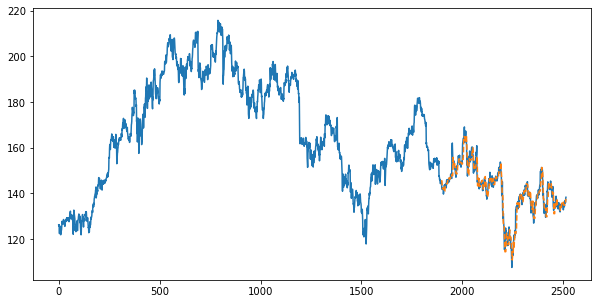

In [38]:
# Using the plot_pred function, plot the predictions and the actual values:
%matplotlib inline
plt.figure(figsize=[10,5])
plot_pred(model_conv)

In this exercise, we built and trained our 1D convolution-based model for stock price prediction. We saw that the number of parameters is very low, and that the training time was much lower.

#### Performance of 1D Convnets

#### Exercise 5.05: Building a Hybrid (1D Convolution and RNN) Model
In this exercise, we will build a model that will employ both 1D convolutions and RNNs and assess the change in performance. Making a hybrid model is straightforward – we'll begin with the convolution layer, the output of which is features in a sequence. The sequence can be fed straight into the RNN layer. Therefore, combining the 1D convolutions with RNNs is as simple as following the Conv1D layer with an RNN layer.

Initialize a sequential model, add a Reshape layer (as in the preceding exercise), and add a Conv1D layer with five filters and a filter size 3:

In [39]:
model_comb = Sequential()
model_comb.add(Reshape((look_back,1), input_shape=(look_back,)))
model_comb.add(Conv1D(5,3,activation='relu'))

In [40]:
# Next, add a SimpleRNN layer with 32 neurons, followed by a Dense layer and an Activation layer:
model_comb.add(SimpleRNN(32))
model_comb.add(Dense(1))
model_comb.add(Activation('linear'))

In [41]:
# Print out the model summary
model_comb.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 10, 1)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 5)              20        
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                1216      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
 activation_2 (Activation)   (None, 1)                 0         
                                                                 
Total params: 1,269
Trainable params: 1,269
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Compile and fit the model on the training data for three epochs:
model_comb.compile(loss='mean_squared_error', optimizer='adam')
model_comb.fit(
    trainX,
    trainY,
    epochs=3,
    batch_size=1,
    verbose=2,
    validation_split=0.1
)

Epoch 1/3
1696/1696 - 3s - loss: 0.0038 - val_loss: 0.0013 - 3s/epoch - 2ms/step
Epoch 2/3
1696/1696 - 2s - loss: 0.0011 - val_loss: 0.0011 - 2s/epoch - 1ms/step
Epoch 3/3
1696/1696 - 2s - loss: 0.0011 - val_loss: 4.0608e-04 - 2s/epoch - 1ms/step


Let's assess the performance first by looking at RMSE. We don't expect this to be very useful for our example, but let's print it out as good practice.

In [43]:
get_model_perf(model_comb)

Train RMSE: 0.03 RMSE
Test RMSE: 0.04 RMSE


The values seem lower, but only a very close look will help us assess the performance of the model.

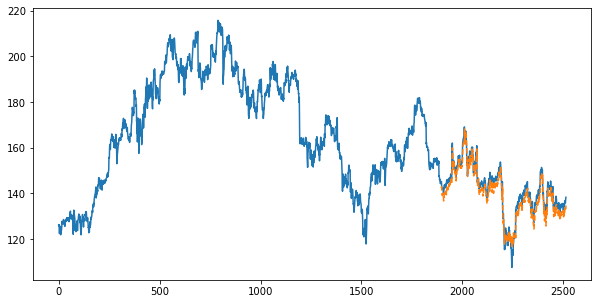

In [44]:
%matplotlib inline
plt.figure(figsize=[10,5])
plot_pred(model_comb)

In this exercise, we saw how we can combine 1D convnets and RNNs to form a hybrid model that can provide high performance. We acknowledge that there is merit in trying this combination for sequence processing tasks.

#### Activity 5.01: Using a Plain RNN Model to Predict IBM Stock Prices
We have seen RNNs in action and can now appreciate the kind of power they bring in sequence prediction tasks. We also saw that RNNs in conjunction with 1D convnets provide great results. Now, let's employ these ideas in another stock price prediction task, this time predicting the stock price for IBM. The dataset can be downloaded from https://packt.live/3fgmqIL. You will visualize the data and understand the patterns. From your understanding of the data, choose a lookback period and build an RNN-based model for prediction. The model will have a 1D convnet as well as a plain RNN layer. You will also employ dropout to prevent overfitting. 

In [45]:
# Load the IBM.csv file, reverse the index, and plot the time series (the Close column) for visual inspection.
ibm = pd.read_csv('IBM.csv')
ibm.head()

,Date,Close,Volume,Open,High,Low
0,1/24/2020,140.56,5580189,143.39,143.9200,140.46
1,1/23/2020,142.87,5657790,144.20,144.4097,142.15
2,1/22/2020,143.89,16470430,143.32,145.7900,142.55
3,1/21/2020,139.17,7244079,137.81,139.3500,137.60
4,1/17/2020,138.31,5623336,136.54,138.3300,136.16


<AxesSubplot:xlabel='Date'>

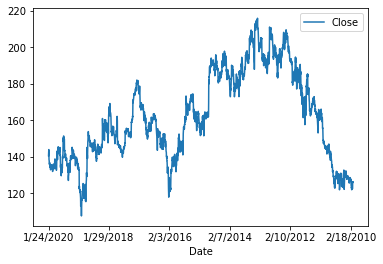

In [46]:
ibm.plot('Date', 'Close')

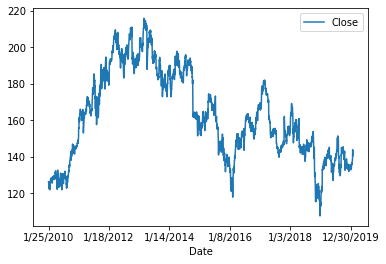

<Figure size 720x360 with 0 Axes>

In [47]:
# reverse the index by sorting dataframe on the index. 
# Plot closing price and supply Date the X-axis.
ibm = ibm.sort_index(ascending=False)
ibm.plot('Date', 'Close')
plt.figure(figsize=[10,5])
plt.show()

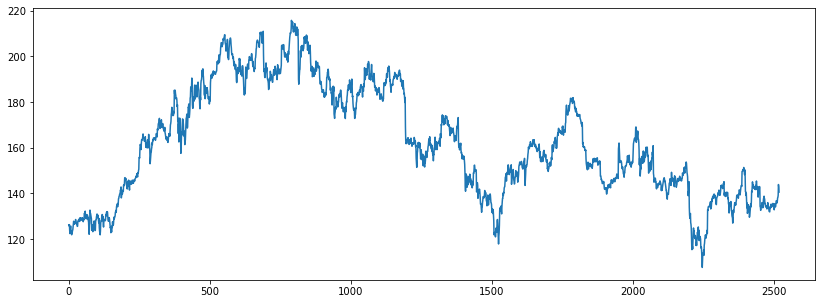

In [48]:
# Extract the values for Close from the DataFrame as a numpy array and plot them using matplotlib.
ibm_ts = ibm.Close.values.reshape(-1,1)
plt.figure(figsize=[14,5])
plt.plot(ibm_ts)
plt.show()

That's what our sequence data looks like. There is no continuous clear trend; the prices rose for a period, after which the stock waxed and waned. The pattern isn't straightforward. We can see that there is some seasonality at a small duration (maybe monthly). Overall, the pattern is rather complex and there are no obvious and easy-to-identify cyclicities in the data that we can exploit. This complex sequence is what we will work with – predicting the stock price for a day using historical values.

In [49]:
# Assign the final 25% data as test data and the first 75% as train data.
train_records = int(len(ibm_ts) * 0.75)
# This is the number of records we'll have in the train set.

In [50]:
ibm_train_data = ibm_ts[:train_records] # from index 0 to train_records value. Index range for train data.
ibm_test_data = ibm_ts[train_records:] # start at index value equal to train_records until the end.
len(train_data), len(test_data)

(1885, 629)

In [51]:
# Using MinMaxScaler from sklearn, scale the train and test data.
# MinMaxScaler already loaded and instantiated
ibm_train_scaled = scaler.fit_transform(ibm_train_data)
ibm_test_scaled = scaler.transform(ibm_test_data)

In [52]:
# Using the get_lookback function we defined in this chapter, get lookback data for the train and test data using a lookback period of 15.
ibm_look_back = 10
ibm_trainX, ibm_trainY = get_lookback(ibm_train_scaled, look_back=ibm_look_back)
ibm_testX, ibm_testY = get_lookback(ibm_test_scaled, look_back=ibm_look_back)

In [53]:
ibm_trainX.shape, ibm_testX.shape

((1888, 10), (630, 10))

As expected, there are 10 features for each example, corresponding to the past 10 days. We have this history for the train data as well as the test data. With that, data preparation is complete. Before we move on to building our first RNN on this data, let's understand RNNs a little more.


From Keras, import all the necessary layers for employing plain RNNs (SimpleRNN, Activation, Dropout, Dense, and Reshape) and 1D convolutions (Conv1D). Also, import mean_squared_error.

In [54]:
# All the other libraries already present
# import mean_squared_error
from sklearn.metrics import mean_squared_error

In [55]:
# Build a model with a 1D convolution layer (5 filters of size 3) and an RNN layer with 32 neurons. Add 25% dropout after the RNN layer. Print the model's summary.
# Initialize a Sequential model and add a Reshape layer to reshape each instance as a vector (look_back, 1)
ibm_model = Sequential()

In [56]:
ibm_model.add(Reshape((ibm_look_back, 1), input_shape=(ibm_look_back,)))
ibm_model.add(Conv1D(5, 3, activation='relu'))

In [57]:
# SimpleRNN
ibm_model.add(SimpleRNN(32))
ibm_model.add(Dropout(0.25))
ibm_model.add(Dense(1))
ibm_model.add(Activation('linear'))

In [58]:
# print out the model summary
ibm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 10, 1)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 8, 5)              20        
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                1216      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
 activation_3 (Activation)   (None, 1)                 0         
                                                                 
Total params: 1,269
Trainable params: 1,269
Non-traina

In [59]:
# Compile the model with the mean_squared_error loss and the adam optimizer. Fit this on the train data in five epochs with a validation split of 10% and a batch size of 1.
ibm_model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

ibm_model.fit(
    ibm_trainX,
    ibm_trainY,
    epochs=5,
    batch_size=1,
    verbose=2,
    validation_split=0.1
)

Epoch 1/5
1699/1699 - 3s - loss: 0.0091 - val_loss: 0.0010 - 3s/epoch - 2ms/step
Epoch 2/5
1699/1699 - 2s - loss: 0.0042 - val_loss: 4.5593e-04 - 2s/epoch - 1ms/step
Epoch 3/5
1699/1699 - 2s - loss: 0.0030 - val_loss: 6.9254e-04 - 2s/epoch - 1ms/step
Epoch 4/5
1699/1699 - 2s - loss: 0.0023 - val_loss: 4.2549e-04 - 2s/epoch - 1ms/step
Epoch 5/5
1699/1699 - 2s - loss: 0.0021 - val_loss: 3.1966e-04 - 2s/epoch - 1ms/step


In [60]:
# Using the get_model_perf method, print the RMSE of the model.
get_model_perf(ibm_model)

Train RMSE: 0.03 RMSE
Test RMSE: 0.04 RMSE


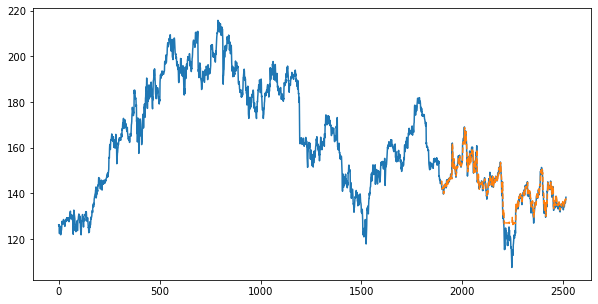

In [62]:
# Plot the predictions – the entire view, as well as a zoomed-in one for a close assessment of the performance.
%matplotlib inline
plt.figure(figsize=[10,5])
plot_pred(ibm_model)

In [ ]:
%matplotlib notebook
plt.figure(figsize=)